## 1.1 Setting up the dependencies

In [1]:
import time
import uuid #---> Used for getting specific uniform identifier
import os
import cv2

In [2]:
images_path = os.path.join('data','images')
number_images= 0

In [3]:
cap = cv2.VideoCapture(0)

for imagnum in range(number_images):
    print('collecting image {}'.format(imagnum))
    ret,frame = cap.read()
    imgname = os.path.join(images_path,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname,frame)
    cv2.imshow('frame',frame)
    time.sleep(0.5)

    
    if cv2.waitKey(1) & 0xFF == ord('q')    :
        break
cap.release()
cv2.destroyAllWindows()

## !.2 Annotate Images with Labels

In [4]:
!labelme


# 2. Review Dataset and Build Image Loading Function

In [5]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt


In [6]:
# For avoiding OOM errors by setting GPU Memory Consumption Growt
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus :
    tf.config.experimental.set_memory_growth(gpu,True)

In [7]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Metal device set to: Apple M1 Pro


True

In [8]:
images = tf.data.Dataset.list_files('data/images/*.jpg',shuffle=False)

In [9]:
images.as_numpy_iterator().next()

b'data/images/d4755528-1330-11ee-9b6c-da95c3cef8a9.jpg'

In [10]:
def load_image(x):
    byt_imag = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byt_imag)
    return img

In [11]:
images = images.map(load_image)

In [12]:
images.as_numpy_iterator().next()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [13]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

## View Raw images as with matpllotlib

In [14]:
image_generator = images.batch(4).as_numpy_iterator()

In [18]:
plot_images = image_generator.next()

StopIteration: 

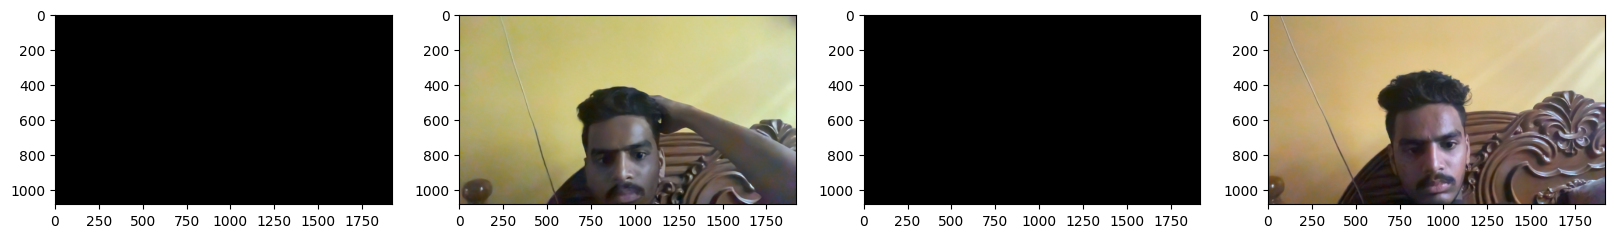

In [19]:
img,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition of Unaugumented Data

## 3.1 Manually split data into train val and test

In [20]:
126*0.7 # train 88

88.19999999999999

In [21]:
126*.15 # test - 19

18.9

In [22]:
# val 19

## 3.2 Move the matching labels

In [23]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)
            

# 4. Apply image Augumentaions on the images using the Albumentaions

## 4.1 Setup Albumentations Transform Pipeline

In [24]:
import albumentations as alb

In [131]:
# augumentor = alb.Compose([alb.RandomCrop(width=(450),height = 450),alb.HorizontalFlip (p=0.5),
#                          alb.RandomBrightnessContrast(p=0.2),alb.RandomGamma(p=0.2),
#                          alb.RGBShift(p=0.2),alb.VerticalFlip(p=0.2)],
#                          bbox_params = alb.BboxParams(format='albumentations',
#                                                      label_fields=['class_labels']))

augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

## 4.2 Load a Test image and Annotation with opencv and json

In [132]:
img = cv2.imread(os.path.join('data','train','images','17c3c022-11e6-11ee-9bb4-da95c3cef8a9.jpg'))

In [133]:
img

array([[[213, 232, 239],
        [215, 234, 241],
        [217, 236, 243],
        ...,
        [153, 187, 203],
        [134, 168, 184],
        [116, 150, 166]],

       [[216, 235, 242],
        [217, 236, 243],
        [218, 237, 244],
        ...,
        [152, 186, 202],
        [138, 172, 188],
        [124, 158, 174]],

       [[219, 238, 245],
        [219, 238, 245],
        [220, 239, 246],
        ...,
        [157, 191, 207],
        [150, 184, 200],
        [143, 177, 193]],

       ...,

       [[188, 207, 222],
        [188, 207, 222],
        [188, 207, 222],
        ...,
        [152, 174, 192],
        [146, 168, 186],
        [147, 169, 187]],

       [[183, 202, 217],
        [185, 204, 219],
        [187, 206, 221],
        ...,
        [148, 170, 188],
        [141, 163, 181],
        [143, 165, 183]],

       [[177, 196, 211],
        [181, 200, 215],
        [186, 205, 220],
        ...,
        [149, 171, 189],
        [146, 168, 186],
        [153, 175, 193]]

In [134]:
with open(os.path.join('data','train','labels','195aa540-11e6-11ee-9bb4-da95c3cef8a9.json'),'r') as f :
    label = json.load(f)

In [135]:
(label['shapes'][0]['label'])

'face'

## 4.3 Extract coordinates and rescale to match image resolution

In [136]:
coords = [0,0,0,0]

In [137]:
coords[0]= label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] =label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [138]:
coords ## ----> (x1,y1(Top coordinates),x2,y2(Bottom Cooordinates))

[726.3934426229508, 323.60655737704917, 1247.704918032787, 887.5409836065573]

In [139]:
x = cv2.imread('data/train/images/149364c0-11e6-11ee-9bb4-da95c3cef8a9.jpg') ## to check the shape of the images

In [140]:
x.shape

(1080, 1920, 3)

In [141]:
coords = list(np.divide(coords,[1920,1080,1920,1080])) ## _---> Dividing the image with the height of image and width of image 
# My webcam resolution is different so i am using the values 

In [142]:
coords

[0.37832991803278687,
 0.2996357012750455,
 0.6498463114754098,
 0.8217972070431087]

## 4.4 Apply Augumentations and view results

In [143]:
augumented = augmentor(image = img,bboxes =[coords],class_labels = ['face'])

In [144]:
augumented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [145]:
(augumented['bboxes'][0])

(0.0, 0.0, 1.0, 1.0)

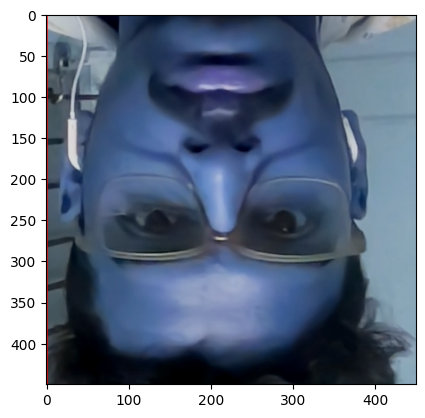

In [146]:
cv2.rectangle(augumented['image'],
              tuple(np.multiply(augumented['bboxes'][0][:2], [1920, 1080]).astype(int)),
              tuple(np.multiply(augumented['bboxes'][0][2:], [1920, 1080]).astype(int)),
              (255, 0, 0), 2)

plt.imshow(augumented['image'])


# 5. Build and Run Augumentation Pieline

In [147]:
## 5.1 Run Augumentation Pipeline

In [148]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords,[1920,1080,1920,1080]))

        try: 
            for x in range(60):
                augumented = augumentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.png'), augumented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augumented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augumented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
image must be numpy array type
image must be numpy array type
image must be numpy array type


In [149]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.png', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [150]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.png', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [151]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.png', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [152]:
train_images.as_numpy_iterator().next()

array([[[0.84160537, 0.70827204, 0.63376224],
        [0.84344363, 0.70618874, 0.6395221 ],
        [0.84460783, 0.70735294, 0.6406863 ],
        ...,
        [0.8748162 , 0.74914217, 0.68694854],
        [0.86960787, 0.74019605, 0.68921566],
        [0.85882354, 0.7343137 , 0.6887255 ]],

       [[0.84313726, 0.70980394, 0.63529414],
        [0.8426471 , 0.70931375, 0.63480395],
        [0.84699756, 0.71366423, 0.63915443],
        ...,
        [0.87444854, 0.74852943, 0.6870711 ],
        [0.85925245, 0.7303309 , 0.6778799 ],
        [0.8254902 , 0.6965686 , 0.64411765]],

       [[0.8397059 , 0.703799  , 0.63057595],
        [0.82892156, 0.69558823, 0.62107843],
        [0.82843137, 0.69509804, 0.62058824],
        ...,
        [0.8700368 , 0.73425245, 0.67493874],
        [0.8101103 , 0.6816176 , 0.6278799 ],
        [0.69411767, 0.5568628 , 0.50232846]],

       ...,

       [[0.49381128, 0.36047795, 0.33302698],
        [0.4990196 , 0.35784313, 0.33039215],
        [0.4981005 , 0

# 6. Prepare Labels

## 6.1 Build Label Loading Function

In [161]:
# def load_labels (label_path):
#     with open(label_path.numpy(),'r',encoding='utf-8') as f:
#         label = json.load(f)
#     return [label['class'], label['bbox']]
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [162]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json',shuffle=False)

In [163]:
train_labels.as_numpy_iterator().next()

b'aug_data/train/labels/12c92cf6-11eb-11ee-bd2f-da95c3cef8a9.0.json'

In [164]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [165]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [166]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [167]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Labels and Image Samples

## 7.1 Create partitions

In [168]:
len(train_images),len(train_labels),len(test_images),len(test_labels),len(val_images),len(val_labels)

(5280, 5280, 1140, 1140, 1140, 1140)

## 7.2 create final dataset

In [169]:
train = tf.data.Dataset.zip(train_images,train_labels)
train = train.shuffle(6000)
train = train.batch(8)
train = train.prefetch(4)

In [170]:
test = tf.data.Dataset.zip(test_images,test_labels)
test = test.shuffle(2000)
test = test.batch(8)
test = test.prefetch(4)

In [171]:
val = tf.data.Dataset.zip(val_images,val_labels)
val = val.shuffle(2000)
val = val.batch(8)
val = val.prefetch(4)

In [172]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0]], dtype=uint8),
 array([[0.    , 0.528 , 0.342 , 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.7476, 0.    , 1.    , 0.933 ],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

## 7.3 View Images and Annotations

In [217]:
data_samples = train.as_numpy_iterator()

In [222]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


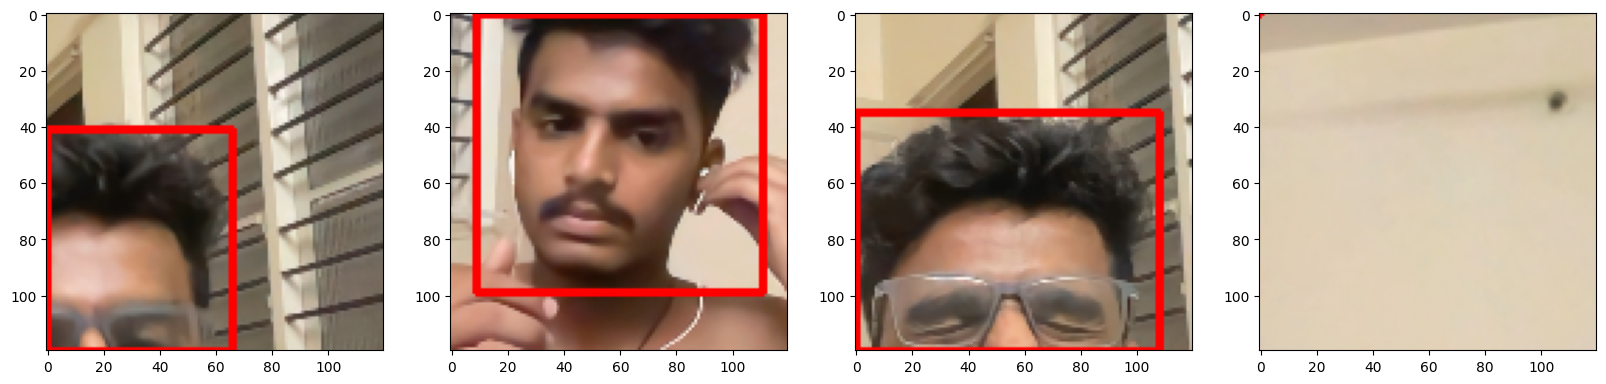

In [223]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Building the Deep Learning Model

## 8.1 Import Layers and base Network

In [176]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Input,MaxPooling2D,Dense,GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## 8.2 Download VGG

In [177]:
vgg = VGG16(include_top=False)

In [178]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## 8.3 Build instance of Network

In [179]:
# def build_model():
#     input_layer = Input(shape=(120,120,3))
#     vgg = VGG16(include_top=False)(input_layer)
    
#     #Classification Model
#     f1 = GlobalMaxPooling2D()(vgg)
#     class1 = Dense(2048,activation = 'relu')(f1)
#     class2 = Dense(1,activation = 'sigmoid')(class1)
    
    
#     f2 = GlobalMaxPooling2D()(vgg)
#     regress1 = Dense(2048,activation='relu')(f2)
#     regress2 = Dense(1,activation='sigmoid')(regress1)
#     facetracker = Model(inputs = input_layer,outputs = [class2,regress2])
#     return facetracker
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [180]:
facetracker = build_model()

In [181]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_5[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_2 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [182]:
X,y = train.as_numpy_iterator().next()

In [186]:
X

array([[[[0.84705883, 0.88235295, 0.7490196 ],
         [0.84656864, 0.88186276, 0.74852943],
         [0.84705883, 0.88235295, 0.7490196 ],
         ...,
         [0.7764706 , 0.8       , 0.6509804 ],
         [0.7764706 , 0.8       , 0.6509804 ],
         [0.7740196 , 0.80245095, 0.654902  ]],

        [[0.8455882 , 0.8808824 , 0.747549  ],
         [0.84313726, 0.8784314 , 0.74509805],
         [0.84313726, 0.8784314 , 0.74509805],
         ...,
         [0.7764706 , 0.7921569 , 0.6509804 ],
         [0.78039217, 0.79607844, 0.654902  ],
         [0.77794117, 0.7985294 , 0.654902  ]],

        [[0.84313726, 0.8784314 , 0.74509805],
         [0.84313726, 0.8784314 , 0.74509805],
         [0.84313726, 0.8784314 , 0.74509805],
         ...,
         [0.779902  , 0.79558825, 0.6544118 ],
         [0.78039217, 0.79607844, 0.654902  ],
         [0.78039217, 0.79607844, 0.654902  ]],

        ...,

        [[0.8352941 , 0.8691176 , 0.72794116],
         [0.83137256, 0.8666667 , 0.72107846]

In [184]:
y

(array([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 1.     , 1.     ],
        [0.     , 0.239  , 1.     , 1.     ],
        [0.208  , 0.     , 1.     , 0.9546 ],
        [0.     , 0.     , 0.1945 , 0.6743 ],
        [0.546  , 0.     , 1.     , 1.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.01494, 0.     , 0.962  , 1.     ]], dtype=float16))

In [185]:
X.shape

(8, 120, 120, 3)

In [187]:
classes,coords = facetracker.predict(X)

1/1 [==============================] - 0s 294ms/step


In [188]:
classes,coords

(array([[0.7045648 ],
        [0.7054227 ],
        [0.65879864],
        [0.7592105 ],
        [0.69608164],
        [0.5730581 ],
        [0.6594638 ],
        [0.70657265]], dtype=float32),
 array([[0.6104614 , 0.50700086, 0.40802917, 0.33808106],
        [0.5969936 , 0.53141373, 0.4814037 , 0.34001014],
        [0.5571373 , 0.5195807 , 0.5140127 , 0.41981763],
        [0.6207312 , 0.45806488, 0.44446054, 0.44806552],
        [0.5955754 , 0.4649782 , 0.3605405 , 0.50647944],
        [0.595498  , 0.42607218, 0.41752398, 0.42388457],
        [0.529154  , 0.43413958, 0.4660081 , 0.4099984 ],
        [0.60562897, 0.47569218, 0.4609797 , 0.331364  ]], dtype=float32))

# 9. Define Losses and Optimizers

## 9.1 Define Optimizer and LR

In [189]:
len(train)

660

In [190]:
batches_per_epoch = len(train)
lr_decay = (1.0/0.75 - 1)/batches_per_epoch
lr_decay

0.0005050505050505049

In [191]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001,decay = lr_decay)

In [197]:
def localization_loss(y_true, yhat): 
    #yhat = tf.reshape(yhat,(1,8))  
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
               
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [198]:
class_loss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Tesstout Loss Metrics

In [199]:
ytrue = y[1]
yhat = coords
#yhat_reshaped = tf.reshape(yhat,(-1,8))
loss = localization_loss(ytrue,yhat).numpy()
loss

14.760519

In [200]:
class_loss(y[0],classes).numpy()

0.5755869

# 10. Train Neural Network

In [201]:
 class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [202]:
model = FaceTracker(facetracker)

In [203]:
model.compile(opt,class_loss,regressloss)

## 10.2 Train

In [204]:
logdir = 'logs'

In [205]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [206]:
hist = model.fit(train,epochs=40,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/40
660/660 [==============================] - 85s 113ms/step - total_loss: 2.0153 - class_loss: 0.5081 - regress_loss: 1.7612 - val_total_loss: 0.6686 - val_class_loss: 0.3528 - val_regress_loss: 0.4922
Epoch 2/40
660/660 [==============================] - 81s 110ms/step - total_loss: 1.4956 - class_loss: 0.3964 - regress_loss: 1.2974 - val_total_loss: 0.0522 - val_class_loss: 0.0606 - val_regress_loss: 0.0219
Epoch 3/40
660/660 [==============================] - 85s 113ms/step - total_loss: 1.2514 - class_loss: 0.3409 - regress_loss: 1.0809 - val_total_loss: 0.3069 - val_class_loss: 0.1350 - val_regress_loss: 0.2394
Epoch 4/40
660/660 [==============================] - 77s 101ms/step - total_loss: 1.0248 - class_loss: 0.2846 - regress_loss: 0.8825 - val_total_loss: 1.5510 - val_class_loss: 0.5381 - val_regress_loss: 1.2819
Epoch 5/40
660/660 [==============================] - 71s 96ms/step - total_loss: 0.8267 - class_loss: 0.2355 - regress_loss: 0.7089 - val_total_loss: 1.331

In [207]:
hist.history

{'total_loss': [2.974273681640625,
  0.42570802569389343,
  0.8557655811309814,
  1.6794365644454956,
  1.8650879859924316,
  0.16588525474071503,
  0.9287606477737427,
  0.30060625076293945,
  0.8158831000328064,
  0.02203565649688244,
  0.07776551693677902,
  0.6565775275230408,
  0.8834215402603149,
  0.027097266167402267,
  0.7351055145263672,
  0.4125089645385742,
  0.03556114807724953,
  0.15133923292160034,
  0.014180484227836132,
  0.007190413307398558,
  0.05946876108646393,
  0.005606666207313538,
  0.00931277684867382,
  0.45127564668655396,
  0.03143763542175293,
  0.018620146438479424,
  0.18047113716602325,
  0.006807389203459024,
  0.016328925266861916,
  0.020372694358229637,
  0.0048872255720198154,
  0.0054011158645153046,
  0.006297275424003601,
  0.00023139046970754862,
  0.0030785973649472,
  0.010086358524858952,
  0.029543181881308556,
  0.015267349779605865,
  0.027453966438770294,
  0.018351182341575623],
 'class_loss': [0.8634521961212158,
  0.0938212275505065

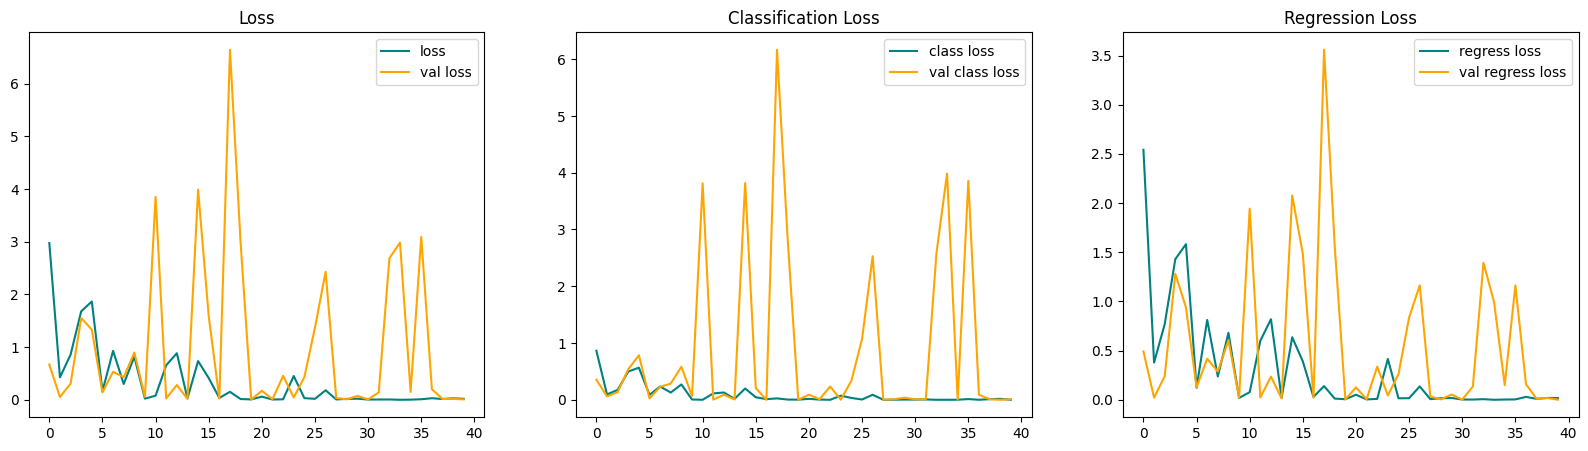

In [208]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()